# Introducción a Detectron2 con Kaggle

Detectron2 es un framework de **Facebook AI Research (FAIR)** para tareas avanzadas de visión por computador, como:

- **Detección de objetos (Object Detection)** → localizar y clasificar objetos en una imagen.  
- **Segmentación de instancias (Instance Segmentation)** → no solo detectar, sino también delinear la forma del objeto.  
- **Detección de keypoints (Keypoint Detection)** → por ejemplo, articulaciones del cuerpo humano.  
- **Segmentación panóptica (Panoptic Segmentation)** → combinación de segmentación de instancias y semántica.  

---

## Objetivo del notebook
En este notebook vamos a realizar un **fine-tuning** de Detectron2 usando un dataset pequeño.  
Esto significa que:
- Partimos de un modelo ya entrenado en **COCO dataset**.  
- Lo ajustamos para detectar **nuevas clases** con un dataset más reducido.  

Esto es mucho más eficiente que entrenar desde cero y es la práctica más común en proyectos reales.  

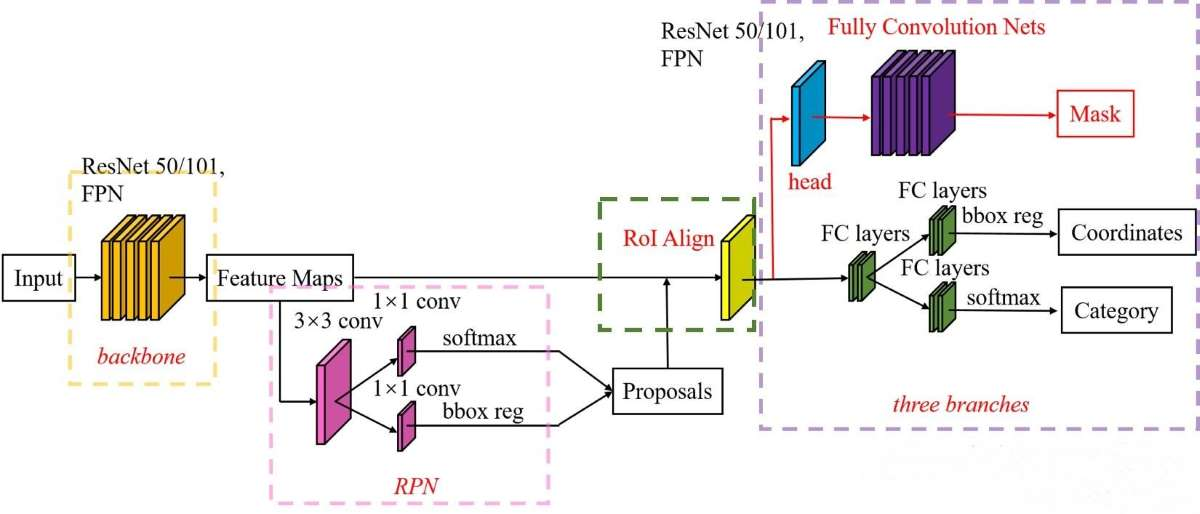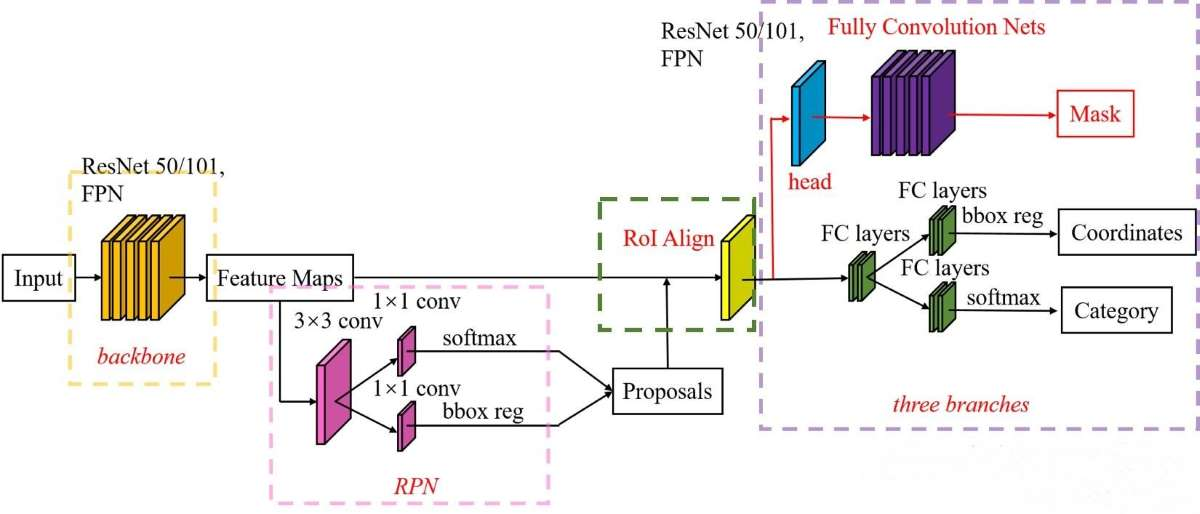

In [1]:
import torch
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

PyTorch: 2.5.1
CUDA available: True
GPU: NVIDIA GeForce RTX 2060


In [2]:
!python -m pip install git+https://github.com/facebookresearch/detectron2.git

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ekbi0zjb
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ekbi0zjb
  Resolved https://github.com/facebookresearch/detectron2.git to commit a1ce2f956a1d2212ad672e3c47d53405c2fe4312
  Preparing metadata (setup.py) ... done


# Fase 1: Setup e instalación de Detectron2

In [5]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 374.5 kB/s  0:01:51m0:00:0100:06


In [6]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
%matplotlib inline

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [7]:
#!wget http://images.cocodataset.org/val2017/000000282037.jpg -q -O input.jpg
!curl -L "http://images.cocodataset.org/val2017/000000282037.jpg" -o "input.jpg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  248k  100  248k    0     0   188k      0  0:00:01  0:00:01 --:--:--  188k


In [8]:
im = cv2.imread("./input.jpg")

plt.figure(figsize=(15,7.5))
plt.imshow(im[..., ::-1])

# Fase 2: Cargar y registrar el dataset

Para este ejercicio práctico vamos a usar el **Balloon Dataset**, un conjunto pequeño de imágenes de globos con anotaciones.

¿Por qué este dataset?
- Es liviano y rápido de descargar.
- Ya está en formato COCO (compatible con Detectron2).
- Perfecto para mostrar un **fine-tuning** sin tardar horas.


In [9]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im[..., ::-1])

# Force CPU since your Torch has no CUDA
#cfg.MODEL.DEVICE = "cpu"
#predictor = DefaultPredictor(cfg)

print(outputs["instances"].pred_classes)

[09/18 15:44:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:15, 11.3MB/s]                                                                         
/root/miniconda3/envs/dl-gpu/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647352509/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([ 0,  0,  0,  0,  0, 35, 32,  0,  0,  0,  0,  0], device='cuda:0')


In [10]:
MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

namespace(name='coco_2017_train',
          json_file='datasets/coco/annotations/instances_train2017.json',
          image_root='datasets/coco/train2017',
          evaluator_type='coco',
          thing_dataset_id_to_contiguous_id={1: 0,
                                             2: 1,
                                             3: 2,
                                             4: 3,
                                             5: 4,
                                             6: 5,
                                             7: 6,
                                             8: 7,
                                             9: 8,
                                             10: 9,
                                             11: 10,
                                             13: 11,
                                             14: 12,
                                             15: 13,
                                             16: 14,
                                   

In [11]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,10))
plt.imshow(out.get_image()[..., ::-1][..., ::-1])

In [12]:
import os
import urllib.request
import zipfile

url = "https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip"
zip_path = "balloon_dataset.zip"

if not os.path.exists(zip_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, zip_path)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(".")

print("Extracted content in:", os.listdir("."))

Extracted content in: ['week2', 'week1', 'requirements.txt', '.git', 'week3', 'balloon_dataset.zip', 'balloon', '.gitignore', 'input.jpg', '__MACOSX']


In [13]:
from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

In [14]:
dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(15,7))
    plt.imshow(out.get_image()[:, :, ::-1][..., ::-1])

# Fase 3: Configuración del modelo y Fine-Tuning

En esta fase vamos a:

1. Cargar un modelo preentrenado de Detectron2 (Mask R-CNN con ResNet-50 + FPN entrenado en COCO).  
2. Ajustarlo para detectar nuestra clase "balloon".  
3. Configurar hiperparámetros clave: learning rate, batch size, número de iteraciones.  
4. Entrenar el modelo usando **fine-tuning**, aprovechando que ya viene preentrenado.

In [15]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025 
cfg.SOLVER.MAX_ITER = 300    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[09/18 15:47:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[09/18 15:47:29 d2.engine.train_loop]: Starting training from iteration 0
[09/18 15:47:40 d2.utils.events]:  eta: 0:02:02  iter: 19  total_loss: 2.154  loss_cls: 0.7137  loss_box_reg: 0.6429  loss_mask: 0.6877  loss_rpn_cls: 0.0364  loss_rpn_loc: 0.00912    time: 0.4361  last_time: 0.4629  data_time: 0.0213  last_data_time: 0.0106   lr: 1.6068e-05  max_mem: 2632M
[09/18 15:47:49 d2.utils.events]:  eta: 0:01:51  iter: 39  total_loss: 1.888  loss_cls: 0.5998  loss_box_reg: 0.6305  loss_mask: 0.5971  loss_rpn_cls: 0.03698  loss_rpn_loc: 0.007941    time: 0.4304  last_time: 0.4614  data_time: 0.0107  last_data_time: 0.0115   lr: 3.2718e-05  max_mem: 2791M
[09/18 15:47:57 d2.utils.events]:  eta: 0:01:42  iter: 59  total_loss: 1.637  loss_cls: 0.465  loss_box_reg: 0.657  loss_mask: 0.4869  loss_rpn_cls: 0.0199  loss_rpn_loc: 0.007591    time: 0.4305  last_time: 0.3918  data_time: 0.0124  last_data_time: 0.0184   lr: 4.9367e-05  max_mem: 2791M
[09/18 15:48:06 d2.utils.events]:  eta: 0:01:33  

In [16]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   
predictor = DefaultPredictor(cfg)

from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im) 
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(15,7))
    plt.imshow(out.get_image()[:, :, ::-1][..., ::-1])

[09/18 15:50:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/root/miniconda3/envs/dl-gpu/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=to

## Test

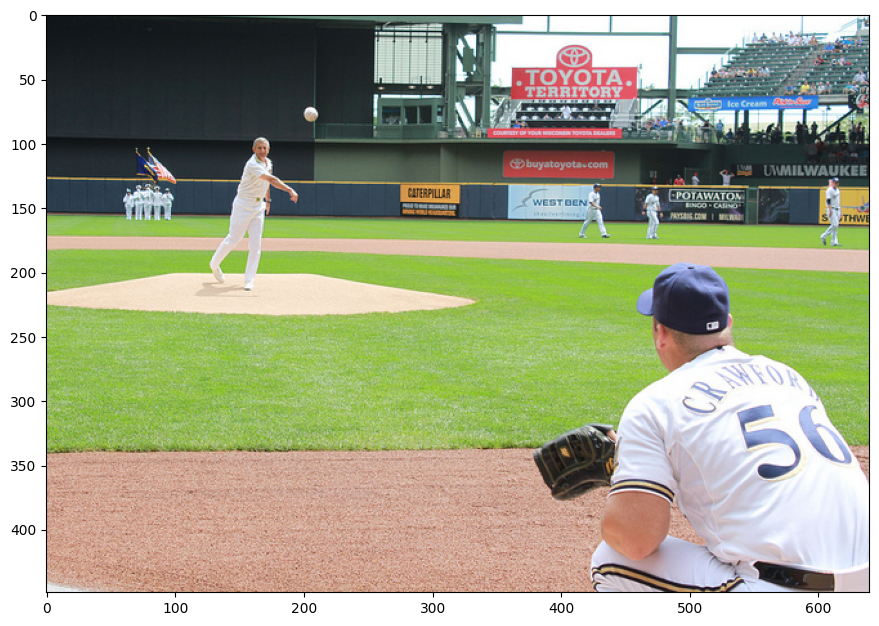

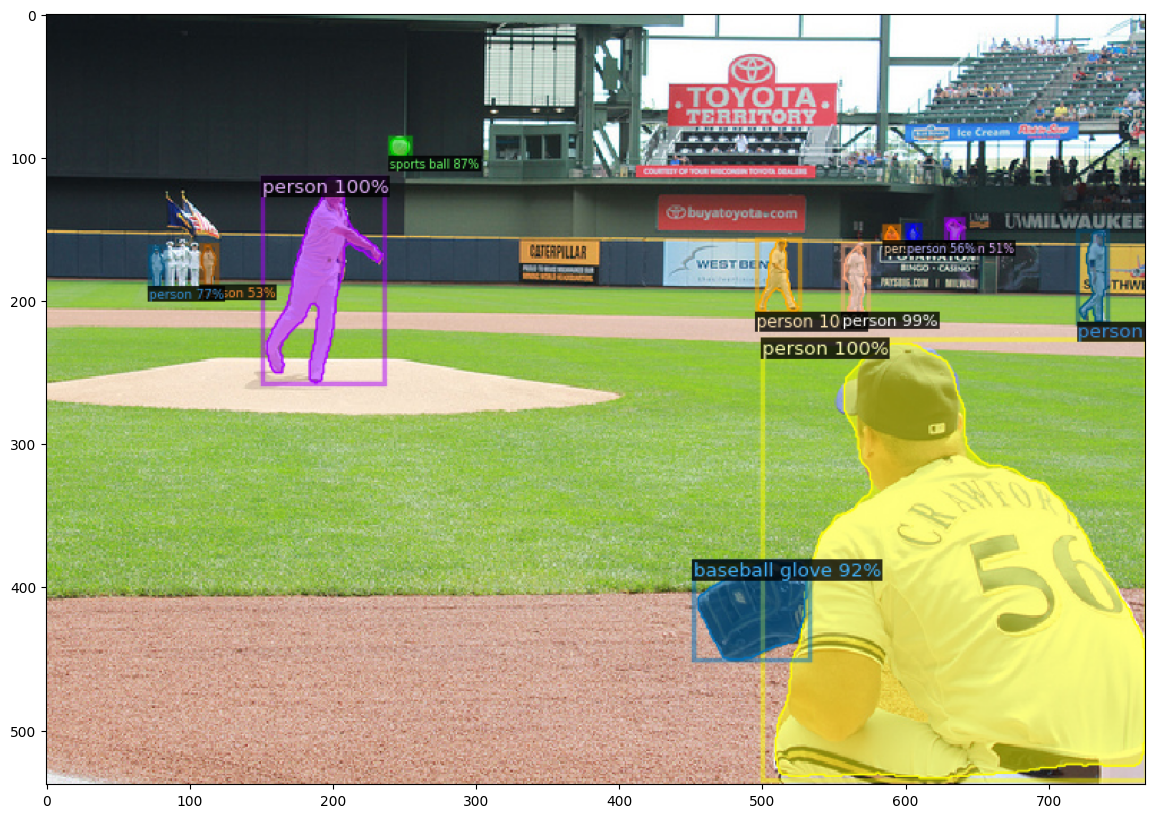

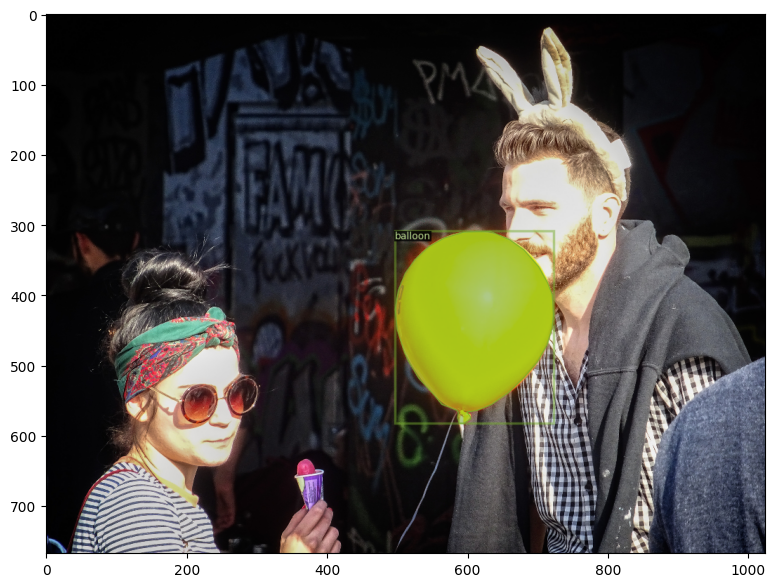

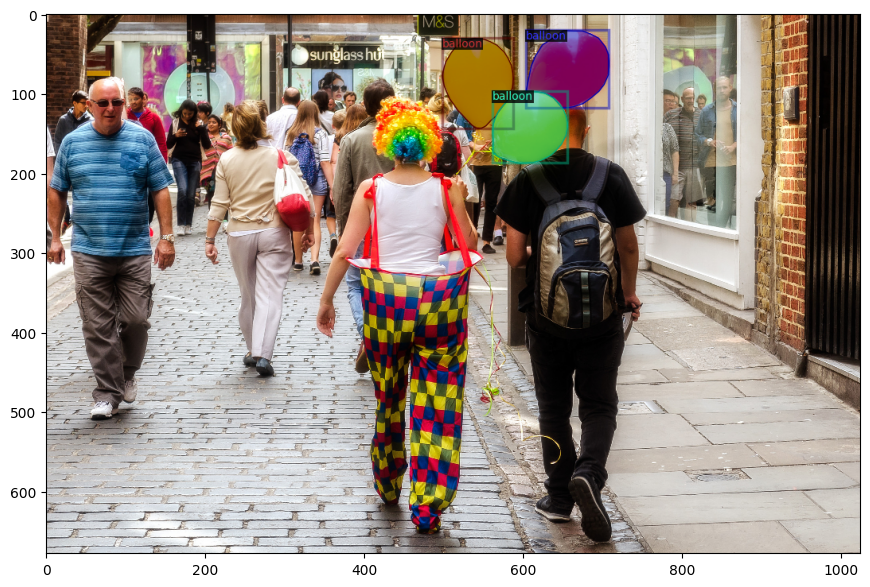

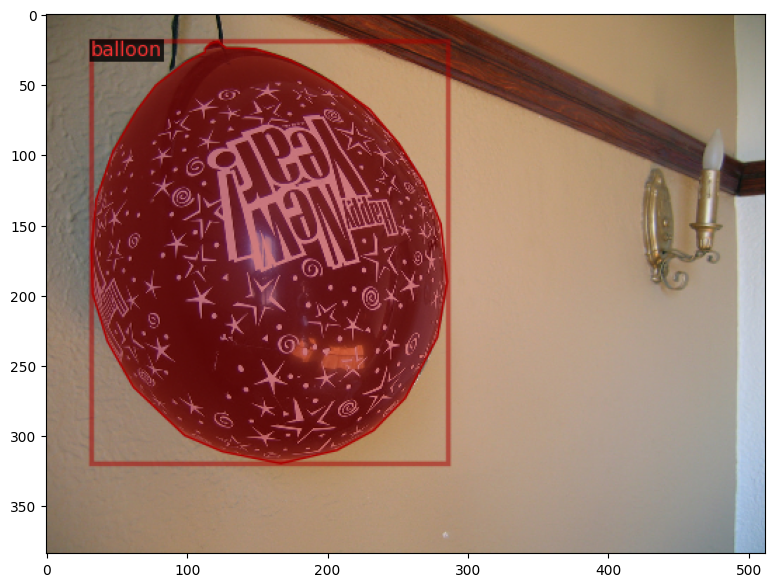

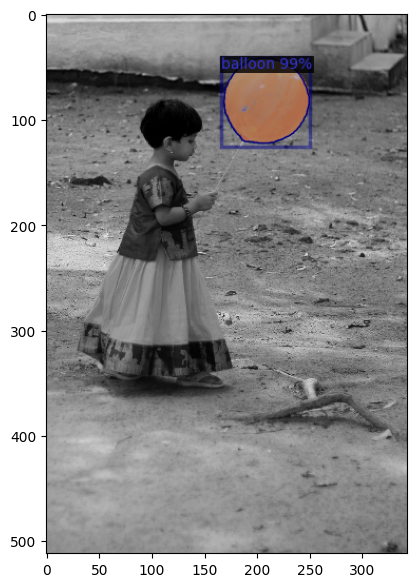

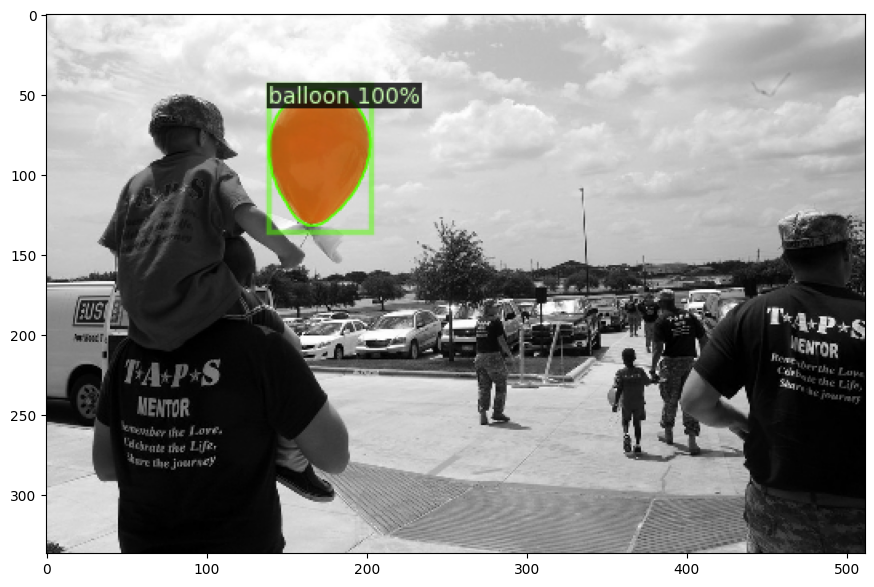

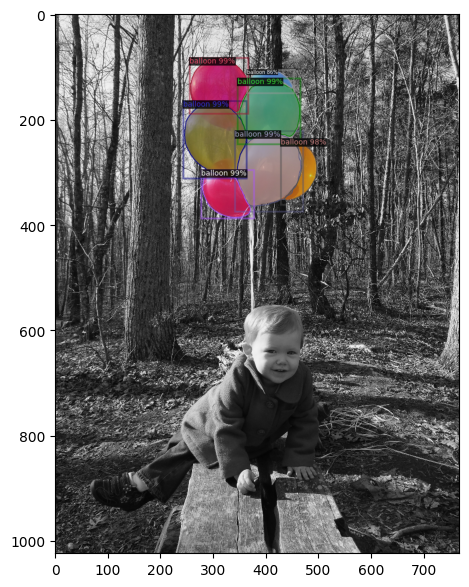

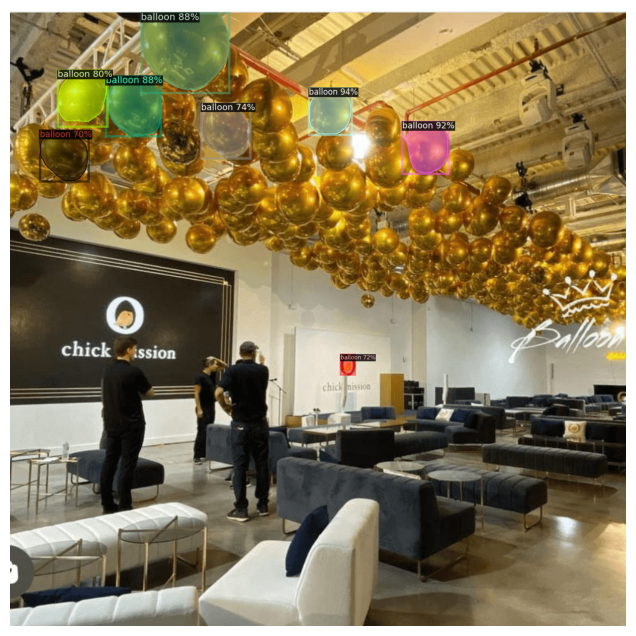

In [17]:
import requests
from io import BytesIO
image_url = "https://cdn11.bigcommerce.com/s-af2f8xc7r2/images/stencil/1280w/uploaded_images/balloon-kings-nj.png"
response = requests.get(image_url)
image_bytes = BytesIO(response.content)
im = np.array(cv2.imdecode(np.frombuffer(image_bytes.read(), np.uint8), cv2.IMREAD_COLOR))

if im is None:
    raise ValueError("It didn't load the image")
    
outputs = predictor(im)

v = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(10, 8))
plt.imshow(out.get_image())
plt.axis("off")
plt.show()


## Exercises

1. Reduce the number of training examples by half. Compare training time, predictions, and loss.

2. Increase the learning rate and analyze the results.

3. Modify the test threshold to make a better prediction

4. Increase the maximum number of iterations and note the impact.

5. Test with your own image and summarize your observations.